In [1]:
import numpy as np
import torch
import pyro.distributions as dist
import pyro
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Code 2.1

In [2]:
ways = np.array([0, 3, 8, 9, 0])
ways / np.sum(ways)

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

# Code 2.2

In [3]:
dist.Binomial(total_count=9, probs=0.5).log_prob(torch.tensor(6)).exp()

tensor(0.1641)

# Code 2.3

In [4]:
points = 20
# define the grid
p_grid = torch.linspace(start=0, end=1, steps=points)

# define prior
prior = torch.ones(points)

# compute likelihood at each value in grid
likelihood = dist.Binomial(total_count=9, probs=p_grid).log_prob(torch.tensor(6)).exp()

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardise the posterior, so it sums to 1
posterior = unstd_posterior / sum(unstd_posterior)

# Code 2.4

[Text(0.5, 0, 'probability of W'),
 Text(0, 0.5, 'posterior probability'),
 Text(0.5, 1.0, '20 pts of grid approx')]

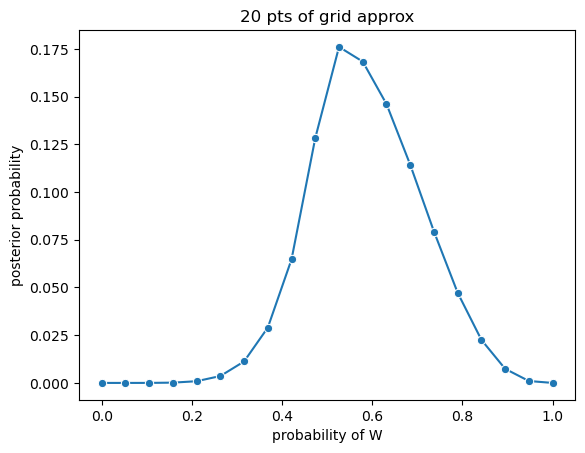

In [33]:
ax = sns.lineplot(x=p_grid.numpy(), y=posterior.numpy(), marker='o')
ax.set(xlabel="probability of W", ylabel="posterior probability", title='20 pts of grid approx')

# Code 2.5

[Text(0.5, 0, 'probability of W'),
 Text(0, 0.5, 'posterior probability'),
 Text(0.5, 1.0, '20 pts of grid approx')]

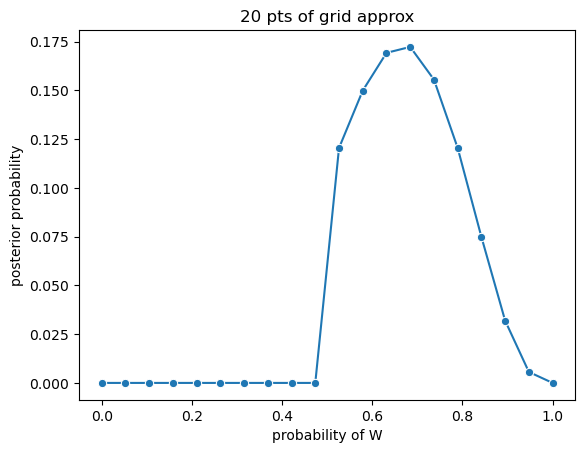

In [6]:
# define prior
prior = torch.where(p_grid <0.5, torch.zeros(1), torch.ones(1))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardise the posterior, so it sums to 1
posterior = unstd_posterior / sum(unstd_posterior)

ax = sns.lineplot(x=p_grid.numpy(), y=posterior.numpy(), marker='o')
ax.set(xlabel="probability of W", ylabel="posterior probability", title='20 pts of grid approx')

[Text(0.5, 0, 'probability of W'),
 Text(0, 0.5, 'posterior probability'),
 Text(0.5, 1.0, '20 pts of grid approx')]

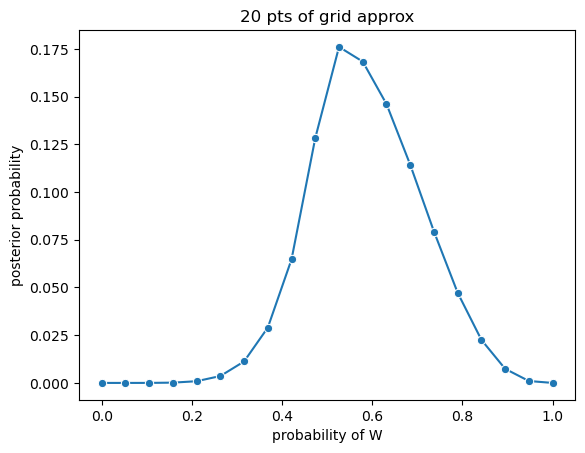

In [7]:
# define prior
prior = torch.exp(-5 * torch.abs(p_grid - 0.5))

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardise the posterior, so it sums to 1
posterior = unstd_posterior / sum(unstd_posterior)

ax = sns.lineplot(x=p_grid.numpy(), y=posterior.numpy(), marker='o')
ax.set(xlabel="probability of W", ylabel="posterior probability", title='20 pts of grid approx')

# Code 2.6
The below is our model:

$p \sim Uniform(0,1)$

$W \sim Binomial(W+L, p)$

$data: W=6, L3$

In [8]:
pyro.clear_param_store()

def model(W, L):
    N = W + L
    
    # Define p as an optimisable param, constrained 0,1
    # p = pyro.param("p", dist.Uniform(0, 1).sample())
    p = pyro.param("p", torch.tensor(0.1))

    # Conditioned on observed W
    pyro.sample("W", dist.Binomial(total_count=N, probs=p), obs=torch.tensor(W, dtype=torch.float))

traced_model = pyro.poutine.trace(model)
vals = []
for _ in tqdm(range(1000)):
    tr = traced_model.get_trace(6., 3.)
    p = tr.nodes["p"]['value']
    log_L = tr.log_prob_sum()
    log_L.backward()
    p.data += 1e-3*p.grad
    p.grad.zero_()
    vals.append(p.item())

print(f"MAP estimate: p={vals[-1]:.4f}")

100%|██████████| 1000/1000 [00:00<00:00, 2024.23it/s]

MAP estimate: p=0.6667


[None,
 Text(0.5, 0, 'steps'),
 Text(0, 0.5, '$p$'),
 Text(0.5, 1.0, 'MAP estiamte for $p$')]

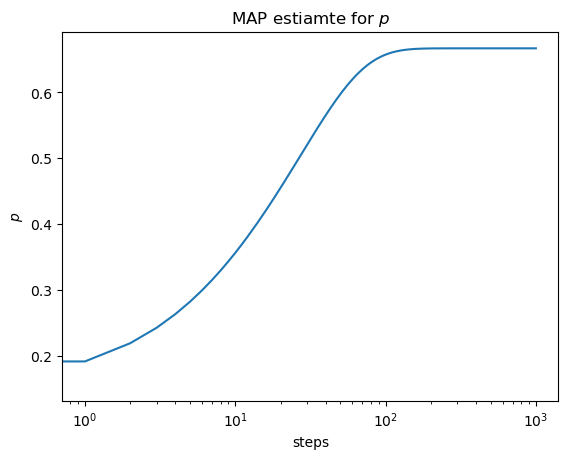

In [9]:
ax = sns.lineplot(vals)
ax.set(xscale='log', xlabel="steps", ylabel='$p$', title="MAP estiamte for $p$")

In [10]:
tr = traced_model.get_trace(6., 3.)
p = tr.nodes['p']['value']
log_L = tr.log_prob_sum()

first_derivative = torch.autograd.grad(log_L, p, create_graph=True)[0]
second_derivative = torch.autograd.grad(first_derivative, p)[0]

print(f"2nd derivative: {second_derivative.item():.4f}")

stddev = 1/torch.sqrt(-second_derivative)
print(f"std is {stddev:.4f}")

2nd derivative: -40.4999
std is 0.1571


# Code 2.7

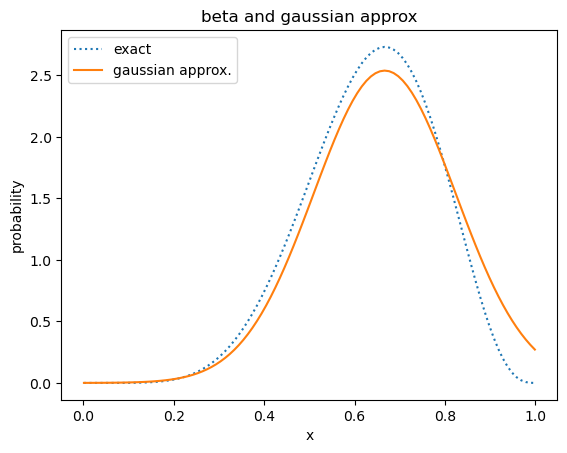

In [11]:
x = torch.linspace(0.001, 0.999, 100)
y1 = dist.Beta(6. + 1, 3. + 1).log_prob(x).exp()
y2 = dist.Normal(p, stddev).log_prob(x).exp().detach()

ax = sns.lineplot(x=x.numpy(), y=y1.numpy(), label="exact", linestyle=":")
sns.lineplot(x=x.numpy(), y=y2.numpy(), ax=ax, label="gaussian approx.")

ax.set(xlabel="x", ylabel='probability', title="beta and gaussian approx")
ax.legend()

# Code 2.8

In [15]:
n_samples = 10000
p = list()
p.append(torch.tensor(0.5))
W = torch.tensor(6.)
L = torch.tensor(3.)
for i in range(1, n_samples):
    # use the prev mean as the center, and take a random small step
    p_new = dist.Normal(p[i-1], 0.1).sample()
    # bound the step to [0,1]
    if (p_new < 0):
        p_new = np.abs(p_new)
    elif (p_new > 1):
        p_new = 2 - p_new

    q0 = dist.Binomial(W+L, p[i-1]).log_prob(W).exp()
    q1 = dist.Binomial(W+L, p_new).log_prob(W).exp()

    acceptance_prob = (q1/q0)

    if dist.Uniform(0,1).sample() < acceptance_prob:
        p.append(p_new)
    else:
        p.append(p[i-1])

C:\Users\alan.nguyen\AppData\Local\Temp\ipykernel_9924\1364727202.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_new = np.abs(p_new)


# Code 2.9

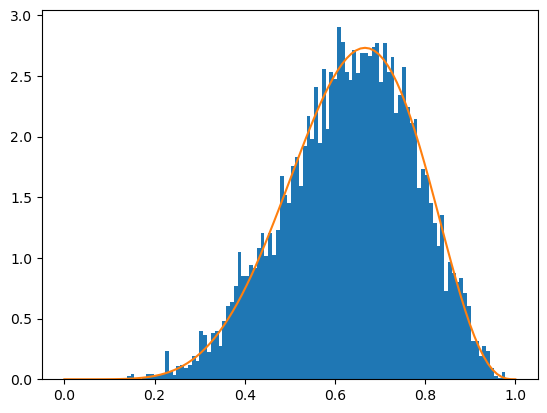

In [16]:
plt.hist(p, bins=100, label='MCMC', density=True)
x = torch.linspace(0,1,100)
y = dist.Beta(W+1, L+1).log_prob(x).exp()
plt.plot(x, y, label='Analytic')

# Practice

## 2E1
The way I think about the statement is the probability of rain GIVEN that it is a mondey Pr(rain | Monday). So (2) is correct.
But (4) is also correct because of conditional probability formula.


## 2E2
It is read as probability of it being a monday GIVEN that it is raining, so (3)

## 2E3
(1) is exactly how we read it
(4) this is Bayes' Theorem equivalent

## 2E4
My view on it is similar to the Frequentist approach I think. Saying "the probability of water is 0.7" means assuming that each toss is random and independent from the last, our thumb is 70% likely to touch a water region. Though, I think what Finetti is trying to say is that probability don't exist because when we observe something, it is realised already, meaning it is 100%. Much like the Schrodinger's cat thought experiment.

## 2M1

In [39]:
def grid_approx(W, L, points=20):
    p_grid = torch.linspace(0, 1, steps=points)
    prior = torch.ones(points)
    likelihood = dist.Binomial(total_count=W+L, probs=p_grid).log_prob(torch.tensor(W)).exp()
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

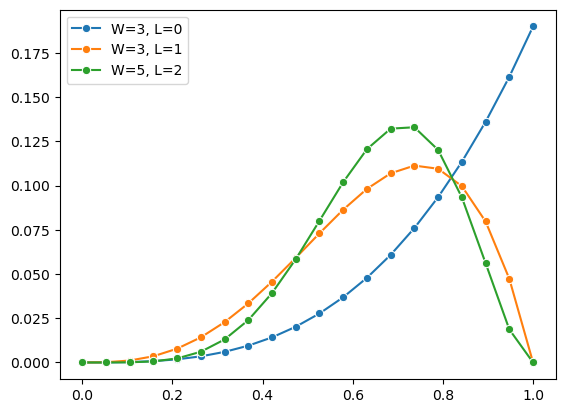

In [43]:
for W, L in((3,0), (3,1), (5,2)):
    x, y = grid_approx(W, L)
    sns.lineplot(x=x.numpy(), y=y.numpy(), marker='o', label=f"W={W}, L={L}")


## 2M2

In [44]:
def grid_approx(W, L, points=20):
    p_grid = torch.linspace(0, 1, steps=points)
    prior = torch.where(p_grid < 0.5, torch.zeros(1), torch.ones(1))
    likelihood = dist.Binomial(total_count=W+L, probs=p_grid).log_prob(torch.tensor(W)).exp()
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

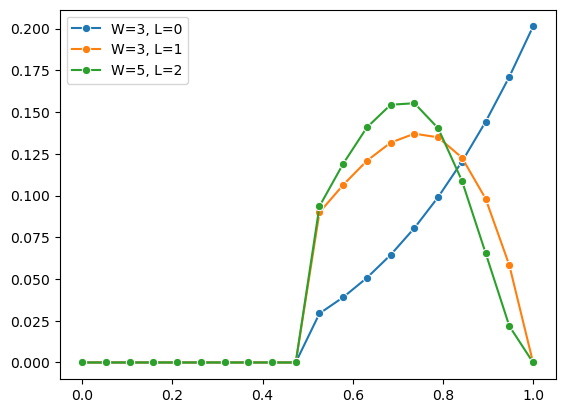

In [45]:
for W, L in((3,0), (3,1), (5,2)):
    x, y = grid_approx(W, L)
    sns.lineplot(x=x.numpy(), y=y.numpy(), marker='o', label=f"W={W}, L={L}")


## 2M3

In [89]:
def model():
    # since "you don't know which", I think a 50/50 chance is less assuming as learned
    planet = pyro.sample("planet", dist.Bernoulli(torch.tensor(0.5)))

    # Let 0=Earth, 1=Mars
    if planet == 0:
        terrain = pyro.sample("terrain", dist.Bernoulli(torch.tensor(0.3))) # similar to chapter 2 code, 0=water and 1=land
    else:
        terrain = pyro.sample("terrain", dist.Bernoulli(torch.tensor(1.)))

#sims variables
planets = list()
terrains = list()

traced_model = pyro.poutine.trace(model)
for _ in range(int(1e4)):
    tr = traced_model.get_trace()
    planets.append(tr.nodes['planet']['value'])
    terrains.append(tr.nodes['terrain']['value'])

planets = np.array(planets)
terrains = np.array(terrains)
# calculate probability
# To know pr(Earth|land), i will do p(land|E)p(E)/p(land) as bayes theorem
count_land_and_earth = ((planets == 0) & (terrains == 1)).sum()
count_earth = (planets == 0).sum()
count_land = (terrains == 1).sum()
total_sim = len(planets)

p_land_given_earth = count_land_and_earth/count_earth
p_earth = count_earth/total_sim
p_land = count_land/total_sim

p_earth_given_land = p_land_given_earth * p_earth / p_land
f"{p_earth_given_land:.2f}"

'0.23'

## 2M4

**Problem statement**: Suppose you have a deck with only three cards. Each card has two sides,
and each side is either black or white. One card has two black sides. The second
card has one black and one white side. The third card has two white sides. Now
suppose all three cards are placed in a bag and shuffled. Someone reaches into
the bag and pulls out a card and places it flat on a table. A black side is shown
facing up, but you don’t know the color of the side facing down. Show that the
probability that the other side is also black is 2/3. Use the counting method
(Section 2 of the chapter) to approach this problem. This means counting up the
ways that each card could produce the observed data (a black side facing up on
the table).

**Counting method**:
So 3 cards defined with this convention -> colour of 1st face, colour of other face
- 1st card: (B, B)
- 2nd card: (B, W) or (W, B) does not matter
- 3rd card: (W, W)

So with a card drawn with 1 face being B, card 3 is out of the game.

Now, we only have card 1 and 2. Which have 4 options (B, B, B, W), but 1 B has been shown. So we have (B, B, W). Thus 2/3.

## 2M5
**Problem statement**: Now suppose there are four cards: B/B, B/W, W/W, and another B/B.
Again suppose a card is drawn from the bag and a black side appears face up.
Again calculate the probability that the other side is black.

**Counting method**:
So 4 cards:
- 1st: (B, B)
- 2nd: (B, W)
- 3rd: (W, W)
- 4th: (B, B)

Using the same logic, 3rd card is out of the ga,e, leaving us with these options: (B, B, B, W, B, B), but 1 B removed, leaving us with (B, B, B, B, W), so 4/5.

## 2M6
**Problem statement**: Imagine that black ink is heavy, and so cards with black sides are heavier
than cards with white sides. As a result, it’s less likely that a card with black
sides is pulled from the bag. So again assume there are three cards: B/B, B/W,
and W/W. After experimenting a number of times, you conclude that for every
way to pull the B/B card from the bag, there are 2 ways to pull the B/W card and
3 ways to pull the W/W card. Again suppose that a card is pulled and a black
side appears face up. Show that the probability the other side is black is now 0.5.
Use the counting method, as before.

**Counting method**:
So 3 cards: BB, BW, WW

- With the first face shown as Black, 3rd card is eliminated
- Leaves us with BB and BW.
- But BW is twice as likely, shifting our sample space to be (B, B) x 1 + (B, W) x 2
- But with 1 face drawn, our sample space for the second face is (B, B) + (W, W) = (B, B, W, W) which means 1/2 to get a black

## 2M7
**Problem statement**: Assume again the original card problem, with a single card showing a
black side face up. Before looking at the other side, we draw another card from
the bag and lay it face up on the table. The face that is shown on the new card is
white. Show that the probability that the first card, the one showing a black side,
has black on its other side is now 0.75. Use the counting method, if you can.
Hint: Treat this like the sequence of globe tosses, counting all the ways to see
each observation, for each possible first card.

**Counting method**:
So 3 cards: BB, BW, WW

- first card cannot be WW, so either BB or BW.
- if BB, then the second can only be BW or WW (2 ways)
- if BW, then the second can only be WW (not BB)
so 3 possible ways out of 4, thus 0.75

## 2H1
**Problem statement**:Suppose there are two species of panda bear. Both are equally common in
the wild and live in the same places. They look exactly alike and eat the same
food, and there is yet no genetic assay capable of telling them apart. They differ
however in their family sizes. Species A gives birth to twins 10% of the time,
otherwise birthing a single infant. Species B births twins 20% of the time,
otherwise birthing singleton infants. Assume these numbers are known with
certainty, from many years of field research.
Now suppose you are managing a captive panda breeding program. You have a
new female panda of unknown species, and she has just given birth to twins.
What is the probability that her next birth will also be twins?

**Solution**:
There are twice as many ways for the first time to be species B. Now, we want to know P(twin 2nd time) -> P(A|twin)*P(twin | A) + P(B | twin 1st time)*P(twin 2nd time | B) = 0.16666666666666666
-> 1/3 * 0.1 + 2/3 * 0.2 = 

## 2H2
**Problem statement**: Recall all the facts from the problem above. Now compute the probability
that the panda we have is from species A, assuming we have observed only the
first birth and that it was twins.

**Solution**: It is just 1/3 because species B is twice as likely.

## 2H3
**Problem statement**:Continuing on from the previous problem, suppose the same panda mother
has a second birth and that it is not twins, but a singleton infant. Compute the
posterior probability that this panda is species A.

**Solution**: 

| Species | Prior  | Likelihood | Posterior (unnormalized)| Normalized Posterior |
|---------|---------------------------------|------------------------------------|-----------------------------------------------|---------------------------------------------------------|
| A       | 1/3                             | 0.9                                | 0.3                                           | 0.36                                                    |
| B       | 2/3                             | 0.8                                | 0.533                                         | 0.64                                                    |

## 2H4
**Problem statement**:A common boast of Bayesian statisticians is that Bayesian inference makes
it easy to use all of the data, even if the data are of different types.
So suppose now that a veterinarian comes along who has a new genetic test
that she claims can identify the species of our mother panda. But the test, like all
tests, is imperfect. This is the information you have about the test:

- The probability it correctly identifies a species A panda is 0.8.
- The probability it correctly identifies a species B panda is 0.65.

The vet administers the test to your panda and tells you that the test is positive
for species A. First ignore your previous information from the births and
compute the posterior probability that your panda is species A. Then redo your
calculation, now using the birth data as well.

**Solution**:
| Species | Prior  | Likelihood | Posterior (unnormalized)| Normalized Posterior |
|---------|-------|-------------|-------------------------|----------------------|
| A       | 0.5   | 0.8         | 0.4                     | 0.6956521739130436   |
| B       | 0.5   | 0.35        | 0.175                   | 0.30434782608695654   |

| Species | Prior  | Likelihood | Posterior (unnormalized)| Normalized Posterior |
|---------|-------|-------------|-------------------------|----------------------|
| A\|test_true_A       | 0.7   | 0.1         | 0.06956521739130436                     | 0.5333333333333333  |
| B\|test_true_B       | 0.3   | 0.2        | 0.060869565217391314                      | 0.4666666666666667   |

| Species | Prior  | Likelihood | Posterior (unnormalized)| Normalized Posterior |
|---------|-------|-------------|-------------------------|----------------------|
| A\|data       | 0.53   | 0.9         | 0.48                     | 0.5625  |
| B\|data       | 0.47   | 0.8        | 0.37333333333333335                      | 0.43750000000000006   |